In [2]:
import os
import re
import nltk
import openpyxl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
def read_and_parse_files(data_directory):
    reviews = []
    
    for root, dirs, files in os.walk(data_directory):
        for file_name in files:
            path = os.path.join(root, file_name)
            parts = path.split(os.sep)
            city = parts[-2]
            hotel_name = file_name.replace('_', ' ')

            with open(path, 'r', encoding='ISO-8859-1') as file: # utf-8 not working on review data
                for line in file:
                    match = re.match(r'(\w+ \d+ \d{4})\s+(.*)', line) # regex for parsing date and review
                    if match:
                        date, review = match.groups()
                        reviews.append({
                            'city': city,
                            'hotel_name': hotel_name,
                            'date': pd.to_datetime(date),
                            'review': review.strip()
                        })

    review_df = pd.DataFrame(reviews)
    return review_df

def preprocess_reviews(review_df):
    review_df['review'] = review_df['review'].str.lower() # convert to lowercase
    review_df['review'] = review_df['review'].str.replace('[^\w\s]', '', regex=True) # remove punctuation
    return review_df

<>:28: SyntaxWarning: invalid escape sequence '\w'
<>:28: SyntaxWarning: invalid escape sequence '\w'
C:\Users\durud\AppData\Local\Temp\ipykernel_15060\1271834116.py:28: SyntaxWarning: invalid escape sequence '\w'
  review_df['review'] = review_df['review'].str.replace('[^\w\s]', '', regex=True) # remove punctuation


In [6]:
import re
import os
import pandas as pd
import logging

def parse_hotel_reviews(data_dir):
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    date_pattern = re.compile(r'(\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec|jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\s\d{1,2}\s\d{4})\s+([^\t\n]*)\s+(.*)')
    data_frames = []

    for root, dirs, files in os.walk(data_dir):
        city = os.path.basename(root)
        for file in files:
            file_path = os.path.join(root, file)
            hotel_name = os.path.splitext(file)[0]  # Assuming the file has no extension
            try:
                with open(file_path, 'r', encoding='ISO-8859-1') as f:
                    content = f.read()

                if not content:
                    logging.warning(f'File {file_path} is empty.')
                    continue

                reviews = date_pattern.findall(content)
                if not reviews:
                    logging.warning(f'No reviews found in file {file_path}. Content: {content[:500]}')
                    continue

                reviews_data = [{'hotel_name': hotel_name, 'hotel_city': city, 'review_date': date, 'hotel_review': review.strip()} for date, _, title, review in reviews]
                if reviews_data:
                    data_frames.append(pd.DataFrame(reviews_data))

            except Exception as e:
                logging.error(f'Error processing file {file_path}: {e}')
                continue

    if data_frames:
        review_df = pd.concat(data_frames, ignore_index=True)
    else:
        review_df = pd.DataFrame(columns=['hotel_name', 'hotel_city', 'review_date', 'hotel_review'])

    return review_df


In [8]:
data_directory = './data'
review_df = parse_hotel_reviews(data_directory)
review_df.to_csv('csv/derlenmis_hotel_review.csv', index=False)

2024-05-18 00:31:53,218 - WARNING - No reviews found in file ./data\las-vegas\usa_nevada_las-vegas_riviera_hotel_casino.rar. Content: Rar! Ïs  
       *tN ïr ²à
 j,&R;3)     usa_nevada_las-vegas_riviera_hotel_casino °roQÌÑQÙ~Ï5¬èr¯O1¥I¦nªyðæ?MU+ã¦Ý¶©¿+è
 ¤8 Ø £Fº2ó:;G5m×¡¤Jî"&d/Î»ç8Û$	èlÀ=!Âk÷íÎ÷ z¹ëË÷=VÏõsæ«õÏóõÕVk;ÍÒê»>ëÖéª÷¿zÎ¦Þz)æ½6=m²ýêz¢iý:oÇ×Ü¹f²ËÝfåN»ª®c²Ï6¸)ýËÕkR»Ü+èUï<ßÏ§«þjxoz¶{±¯c¯­Ý	åºõ¯ýh^æ6!q~w¬½óü÷Ìë#_ÚÎùý~'ÉVN²U?Îó¨óÁ×Üã¢uíô¥Õþ¾ÁæÖÇ[µý¬ôÃIÚ¯oîMØÏ=ZvîØU?Á/QóõmZå!;¼ûÍ®ú2ì´a1Ù-Õù»¦W~à¼ÞþïôÆàìùÓU?ÁÔv+gºíøñÖ´ù:ñÖ>]t}×½©ùuþ~Á 


In [12]:
def preprocess_reviews(review_df):
    review_df['hotel_review'] = review_df['hotel_review'].str.lower() # convert to lowercase
    review_df['hotel_review'] = review_df['hotel_review'].str.replace('[^\w\s]', '', regex=True) # remove punctuation
    return review_df

<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
C:\Users\durud\AppData\Local\Temp\ipykernel_15060\919734508.py:3: SyntaxWarning: invalid escape sequence '\w'
  review_df['hotel_review'] = review_df['hotel_review'].str.replace('[^\w\s]', '', regex=True) # remove punctuation


In [13]:
review_df = preprocess_reviews(review_df)
review_df.to_csv('csv/processed_hotel_reviews.csv', index=False)

print(review_df.head())

                            hotel_name hotel_city  review_date  \
0  china_beijing_aloft_beijing_haidian    beijing  Oct 12 2009   
1  china_beijing_aloft_beijing_haidian    beijing  Sep 25 2009   
2  china_beijing_aloft_beijing_haidian    beijing   Aug 4 2009   
3  china_beijing_aloft_beijing_haidian    beijing  Jul 17 2009   
4  china_beijing_aloft_beijing_haidian    beijing  May 30 2009   

                                        hotel_review  
0  i stayed in this hotel for one night as this i...  
1  stayed two nights at aloft on the most recent ...  
2  we stayed at the aloft beijing haidian for 5 n...  
3  i am glad to be the first person to post photo...  
4  stayed there for one night the hotel is locate...  


In [7]:
# Seed keywords
feature_keywords = {
    'cleanliness': ['clean', 'spotless', 'tidy', 'smell good'],
    'room': ['room', 'suite', 'space', 'chamber', 'huge', 'large', 'hot shower'],
    'service': ['service', 'support', 'help', 'assistance', 'helpful', 'cheerful', 'nice staff', 'good staff', 'pleasant'],
    'location': ['good location', 'nice spot', 'good spot', 'good area', 'not far', 'close', 'not distant', 'walking', 'walk'],
    'value': ['value', 'price', 'cost', 'worth', 'cheap', 'not expensive'],
    'safety': ['safety', 'secure', 'safe', 'not dangereous'],
    'comfort': ['comfort', 'comfortable'],
    'transportation': ['transportation', 'transit', 'transport', 'travel', 'bus', 'metro', 'train', 'station', 'not far'],
    'noise': ['no noise', 'not noisy', 'quiet', 'not loud', 'silent', 'no sound']
}   

# WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

In [8]:
# Expand each category with synonyms
expanded_keywords = {}
for feature, keywords in feature_keywords.items():
    expanded_set = set()
    for keyword in keywords:
        expanded_set.update(get_synonyms(keyword))
    expanded_keywords[feature] = expanded_set

# Display expanded keywords for review
for feature, keywords in expanded_keywords.items():
    print(f"{feature.capitalize()} Keywords: {sorted(keywords)}\n") 

Cleanliness Keywords: ['blank', 'clean', 'clean-living', 'clean_and_jerk', 'clean_house', 'clean_up', 'cleanse', 'clear', 'fair', 'fairly', 'fresh', 'goodish', 'goodly', 'healthy', 'hefty', 'houseclean', 'immaculate', 'kempt', 'light', 'make_clean', 'neat', 'neaten', 'pick', 'plum', 'plumb', 'respectable', 'scavenge', 'sizable', 'sizeable', 'speckless', 'spic', 'spic-and-span', 'spick', 'spick-and-span', 'sporting', 'sportsmanlike', 'sporty', 'spotless', 'square_away', 'straighten', 'straighten_out', 'strip', 'tidy', 'tidy_up', 'unclouded', 'uncontaminating', 'uninfected', 'unobjectionable', 'white']

Room Keywords: ['Brobdingnagian', 'bedchamber', 'bedroom', 'big', 'blank', 'blank_space', 'board', 'boastfully', 'bombastic', 'chamber', 'cortege', 'declamatory', 'distance', 'elbow_room', 'enceinte', 'entourage', 'expectant', 'gravid', 'great', 'heavy', 'huge', 'immense', 'infinite', 'large', 'magnanimous', 'orotund', 'outer_space', 'place', 'prominent', 'quad', 'retinue', 'room', 'rooms

In [ ]:
# Using vaderSentiment for sentiment analysis
analyzer = SentimentIntensityAnalyzer() 

def analyze_review_sentiments(review_df, feature_keywords):
    for feature in feature_keywords.keys():
        review_df[f'{feature}_sentiment'] = 0.0

    for index, row in review_df.iterrows():
        review_text = row['review']
        sentences = nltk.sent_tokenize(review_text)
        feature_sentiments = {feature: [] for feature in feature_keywords.keys()}

        for sentence in sentences:
            for feature, keywords in feature_keywords.items():
                if any(keyword in sentence for keyword in keywords):
                    sentiment_score = analyzer.polarity_scores(sentence)['compound']
                    feature_sentiments[feature].append(sentiment_score)

        for feature, sentiments in feature_sentiments.items():
            if sentiments:
                average_sentiment = sum(sentiments) / len(sentiments)
                review_df.at[index, f'{feature}_sentiment'] = average_sentiment
    
    return review_df

review_df = analyze_review_sentiments(review_df, expanded_keywords)
review_df.to_csv('csv2/hotel_reviews_with_sentiments.csv', index=False)
print(review_df.head())

In [3]:
review_df = pd.read_csv('csv2/hotel_reviews_with_sentiments.csv')

In [4]:
def aggregate_scores(review_df):
    aggregated_df = review_df.groupby('hotel_name').agg({
        'cleanliness_sentiment': 'mean',
        'room_sentiment': 'mean',
        'service_sentiment': 'mean',
        'location_sentiment': 'mean',
        'value_sentiment': 'mean',
        'safety_sentiment': 'mean',
        'comfort_sentiment': 'mean',
        'transportation_sentiment': 'mean',
        'noise_sentiment': 'mean'
    }).reset_index()

    return aggregated_df

aggregated_scores_df = aggregate_scores(review_df)
aggregated_scores_df.to_csv('csv2/aggregated_hotel_scores.csv', index=False)

print(aggregated_scores_df.head())

                              hotel_name  cleanliness_sentiment  \
0  are dubai abc almanar hotel apartment               0.248275   
1          are dubai admiral plaza hotel               0.387346   
2   are dubai al bustan centre residence               0.287464   
3       are dubai al bustan rotana dubai               0.580000   
4      are dubai al hijaz heritage motel               0.651900   

   room_sentiment  service_sentiment  location_sentiment  value_sentiment  \
0        0.418475           0.418475            0.418475         0.418475   
1        0.425322           0.206839            0.428485         0.387105   
2        0.337436           0.203371            0.350521         0.406479   
3        0.683537           0.627134            0.649145         0.680430   
4        0.651900           0.535125            0.651900         0.651900   

   safety_sentiment  comfort_sentiment  transportation_sentiment  \
0          0.418475           0.000000                  0.418475  

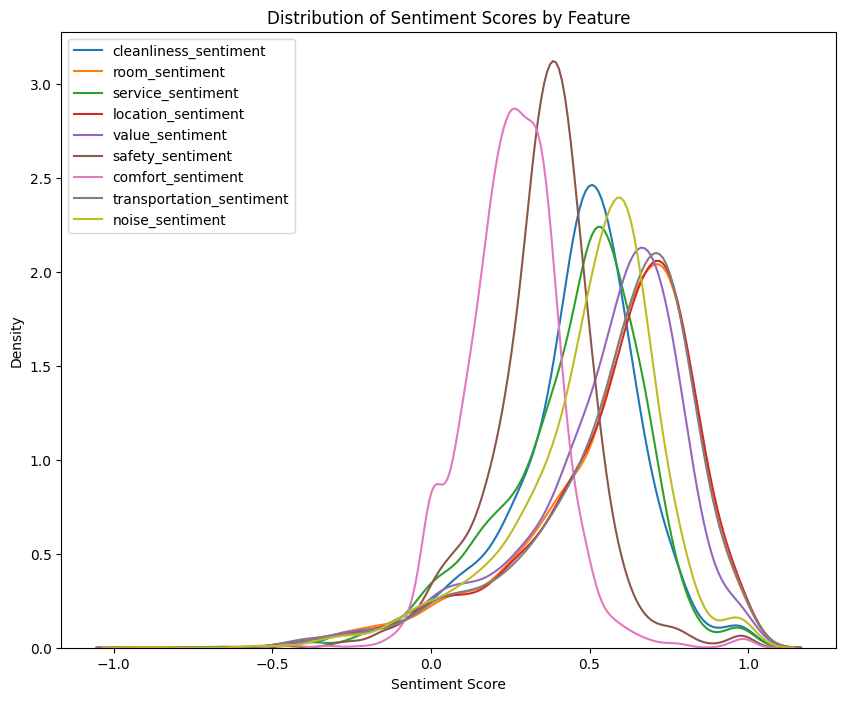

In [3]:
aggregated_scores_df = pd.read_csv('csv2/aggregated_hotel_scores.csv')

# Plotting each feature's sentiment scores across all hotels
plt.figure(figsize=(10, 8))
for column in aggregated_scores_df.columns[1:]:  # Skip 'hotel_name' column
    sns.kdeplot(aggregated_scores_df[column], label=column)

plt.title('Distribution of Sentiment Scores by Feature')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

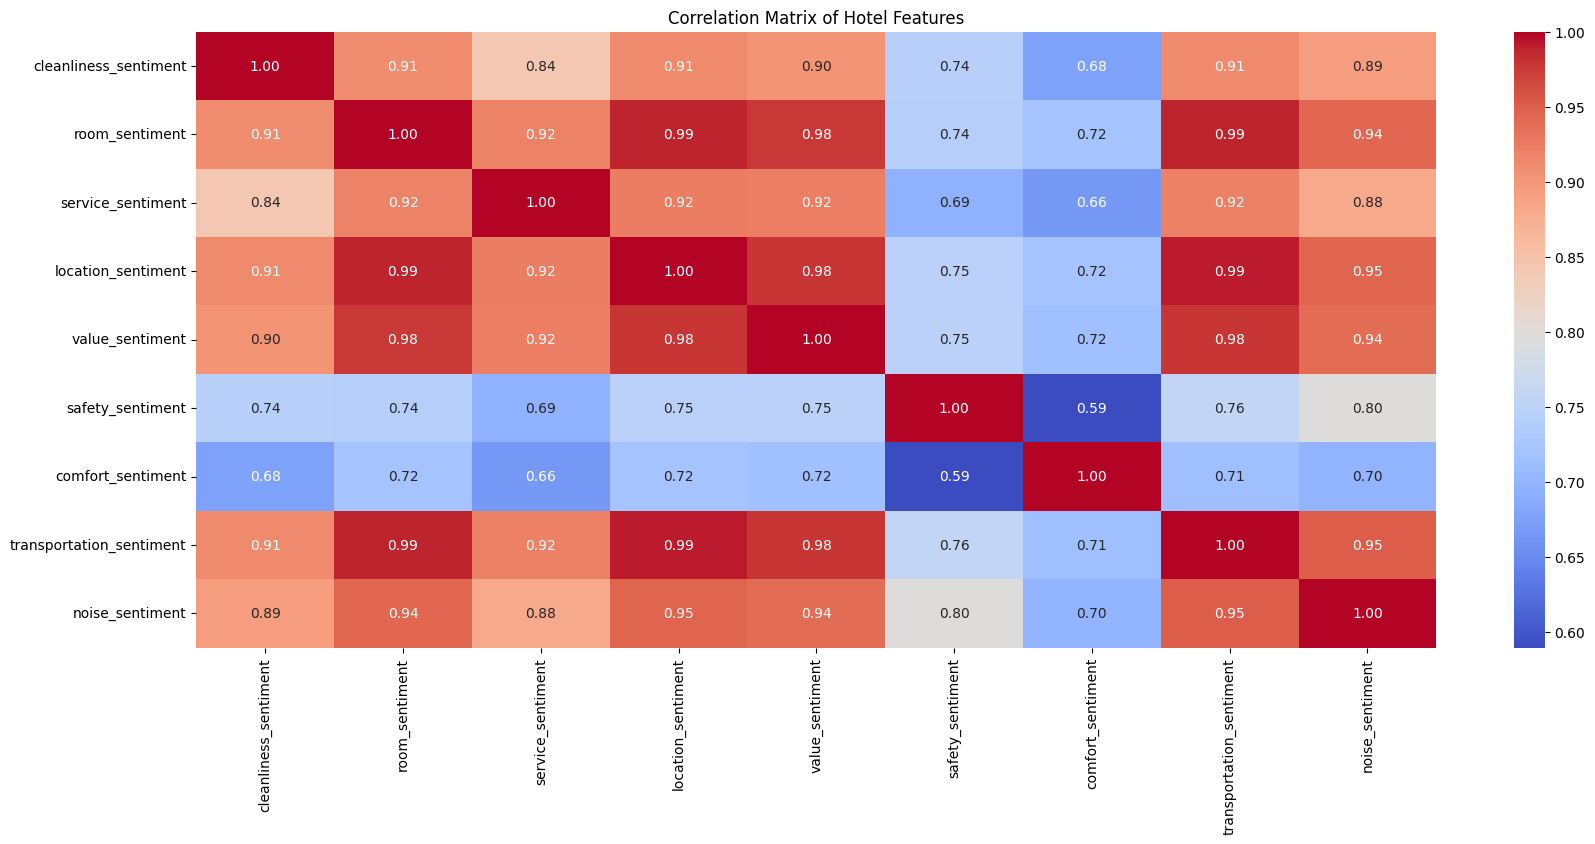

In [5]:
# Plot the correlation matrix to display the correlation between each sentiment
correlation_matrix = aggregated_scores_df.drop('hotel_name', axis=1).corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Hotel Features')
plt.show()

In [6]:
aggregated_scores_df['overall_sentiment'] = aggregated_scores_df[['cleanliness_sentiment', 'room_sentiment', 'service_sentiment', 
                                  'location_sentiment', 'value_sentiment', 'safety_sentiment',
                                  'comfort_sentiment', 'transportation_sentiment', 'noise_sentiment']].mean(axis=1) 

threshold = aggregated_scores_df['overall_sentiment'].median()
aggregated_scores_df['customer_satisfaction'] = (aggregated_scores_df['overall_sentiment'] > threshold).astype(int)

In [7]:
# Define customer_satisfaction based on comfort_sentiment being above a certain threshold
comfort_threshold = aggregated_scores_df['comfort_sentiment'].median()
aggregated_scores_df['customer_satisfaction'] = (aggregated_scores_df['comfort_sentiment'] > comfort_threshold).astype(int)

In [8]:
features = ['cleanliness_sentiment', 'room_sentiment', 'service_sentiment', 
            'location_sentiment', 'value_sentiment', 'safety_sentiment',
            'comfort_sentiment', 'transportation_sentiment', 'noise_sentiment']
target = 'customer_satisfaction'

X = aggregated_scores_df[features]
y = aggregated_scores_df[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       394
           1       0.92      0.95      0.93       377

    accuracy                           0.93       771
   macro avg       0.93      0.93      0.93       771
weighted avg       0.93      0.93      0.93       771

Confusion Matrix:
[[362  32]
 [ 20 357]]
ROC AUC Score: 0.9886964951729523


In [11]:
# Coefficients of the model
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_[0]})
print(feature_importance.sort_values(by='Coefficient', ascending=False))

                    Feature  Coefficient
6         comfort_sentiment    15.563420
1            room_sentiment     1.706713
3        location_sentiment     1.114234
7  transportation_sentiment     0.934489
4           value_sentiment     0.654407
8           noise_sentiment     0.203431
2         service_sentiment     0.120737
0     cleanliness_sentiment     0.054829
5          safety_sentiment    -0.245487


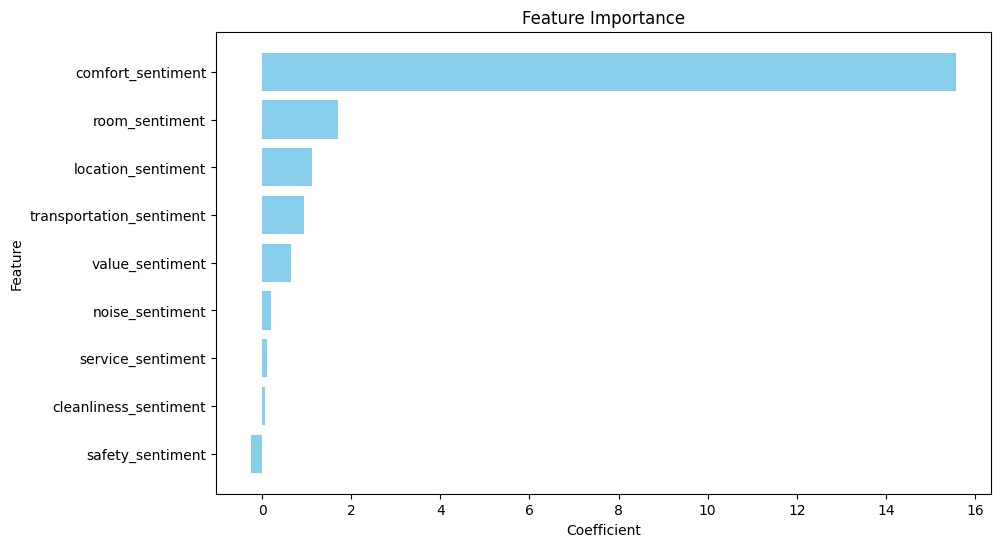

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the features and their corresponding coefficients
features = [
    'cleanliness_sentiment', 'room_sentiment', 'service_sentiment', 
    'location_sentiment', 'value_sentiment', 'safety_sentiment', 
    'comfort_sentiment', 'transportation_sentiment', 'noise_sentiment'
]
coefficients = [
    0.054829, 1.706713, 0.120737, 1.114234, 
    0.654407, -0.245487, 15.563420, 0.934489, 0.203431
]

# Create DataFrame
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient values
sorted_feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_importance['Feature'], sorted_feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
plt.show()


In [32]:
# Example of model with L2 regularization
model_tuned = LogisticRegression(max_iter=1000, penalty='l2', C=0.1)  # 'C' is the inverse of regularization strength
model_tuned.fit(X_train, y_train)
y_pred_tuned = model_tuned.predict(X_test)
print("Tuned Model ROC AUC Score:", roc_auc_score(y_test, model_tuned.predict_proba(X_test)[:, 1]))

Tuned Model ROC AUC Score: 0.9429034994412204


In [17]:
data = pd.read_csv('csv2/aggregated_hotel_scores.csv')

features = ['cleanliness_sentiment', 'room_sentiment', 'service_sentiment', 
            'location_sentiment', 'value_sentiment', 'safety_sentiment', 
            'comfort_sentiment', 'transportation_sentiment', 'noise_sentiment']

# Normalize the sentiment scores to a 1-5 scale
def normalize_scores(row, min_val, max_val):
    return 1 + 4 * (row - min_val) / (max_val - min_val) if max_val > min_val else 3

for feature in features:
    min_score = data[feature].min()
    max_score = data[feature].max()
    data[feature] = data[feature].apply(normalize_scores, args=(min_score, max_score))

data.rename(columns={feat: feat.replace('_sentiment', '_grade') for feat in features}, inplace=True)

data.to_csv('csv2/hotel_grades.csv', index=False)
print(data.head())

                              hotel_name  cleanliness_grade  room_grade  \
0  are dubai abc almanar hotel apartment           3.247567    3.768182   
1          are dubai admiral plaza hotel           3.572117    3.782706   
2   are dubai al bustan centre residence           3.339023    3.596284   
3       are dubai al bustan rotana dubai           4.021713    4.330424   
4      are dubai al hijaz heritage motel           4.189506    4.263317   

   service_grade  location_grade  value_grade  safety_grade  comfort_grade  \
0       3.545764        3.768182     3.768182      3.592630       2.302740   
1       3.015791        3.789416     3.701641      3.372444       2.581834   
2       3.007107        3.624041     3.742736      3.107806       2.522955   
3       4.068283        4.257473     4.323835      3.553906       2.751571   
4       3.837876        4.263317     4.263317      3.870874       2.954751   

   transportation_grade  noise_grade  
0              3.768182     3.768182  
1 

In [18]:
data = pd.read_csv('csv2/hotel_grades.csv')  # Load your data if not already in a DataFrame
with pd.ExcelWriter('csv2/hotel_grades.xlsx', engine='openpyxl') as writer:
    data.to_excel(writer, index=False, sheet_name='Hotel Grades')

    workbook = writer.book
    worksheet = writer.sheets['Hotel Grades']

    for col in worksheet.columns:
        max_length = 0
        column = col[0].column_letter  # Get the column name
        for cell in col:
            try:  
                if len(str(cell.value)) > max_length:
                    max_length = len(cell.value)
            except:
                pass
        adjusted_width = (max_length + 2) * 1.2
        worksheet.column_dimensions[column].width = adjusted_width

    header_font = openpyxl.styles.Font(bold=True, color='FFFFFF')
    header_fill = openpyxl.styles.PatternFill(start_color='666666', end_color='666666', fill_type='solid')
    for cell in worksheet['1:1']:  # Apply formatting to the first row
        cell.font = header_font
        cell.fill = header_fill

In [11]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})

feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print(feature_importance)


                    Feature  Coefficient
6         comfort_sentiment    15.572350
1            room_sentiment     1.708869
3        location_sentiment     1.101875
7  transportation_sentiment     0.944025
4           value_sentiment     0.637631
8           noise_sentiment     0.217815
2         service_sentiment     0.113090
0     cleanliness_sentiment     0.070883
5          safety_sentiment    -0.253143


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
coefficients_reshaped = coefficients.reshape(-1, 1)
normalized_coefficients = scaler.fit_transform(coefficients_reshaped).flatten()

feature_importance_normalized = pd.DataFrame({
    'Feature': features,
    'Normalized Coefficient': normalized_coefficients
})

print(feature_importance_normalized.sort_values(by='Normalized Coefficient', ascending=False))
